In [1]:
%matplotlib inline
import fsps
import matplotlib.pyplot as plt
import numpy as np

* add_igm_absorption includes IGM absorption via Madau 1995
* zred is redshift
* zmet = 1.0 by default, metallicity 
* sfh = 0 is SSP model (all stars have same age and metallicity) 
* tage = Myr age
* sfh = tabular sfr per year since big bang
* dust_type = 2; See Calzetti et al 2000. Dust attenuation is applied to all starlight equally (old and new). This is set by dust_2
* dust_2 small attenuation due to ISM dust for all stars. 

In [2]:
sp = fsps.StellarPopulation(zred=3., const=1.0, sfh=3, tage=0.5, add_igm_absorption=True,
                            zmet = 1., dust1=0.0, dust2=0.1, dust_type=2 )

Create arrays of age since big bang in Gyr and the constant star formation rate of 5 solar mass / yr.

In [3]:
a = np.arange(0.1, 0.6, 0.1)
sfr = np.full(5, 5.0)

Set the star formation history with a constant star formation rate.

In [4]:
sp.set_tabular_sfh(age = a, sfr = sfr)

Below we print the AB magnitudes in desired bands. They are extremely faint right now and I think this is because the star formation rate is by default normalized to 1. I need to figure out how to make it 5. 

In [5]:
mags = sp.get_mags(zmet = 1., tage=0.5, bands=['wfc_acs_f435w', 'wfc_acs_f606w', 'wfc_acs_f775w', 'wfc_acs_f850lp', 'wfc3_ir_f105w', 'wfc3_ir_f125w', 'wfc3_ir_f160w', 'jwst_f200w', 'jwst_f277w', 'jwst_f356w', 'jwst_f444w'])
print 'HST F435W: ', mags[0]
print 'HST F606W: ', mags[1]
print 'HST F775W: ', mags[2]
print 'HST F850LP: ', mags[3]
print 'HST F105W: ', mags[4]
print 'HST F125W: ', mags[5]
print 'HST F160W: ', mags[6]
print 'JWST F200W: ', mags[7]
print 'JWST F277W: ', mags[8]
print 'JWST F356W: ', mags[9]
print 'JWST F444W: ', mags[10]

HST F435W:  25.685180586652734
HST F606W:  25.194646169018057
HST F775W:  25.245591101064576
HST F850LP:  25.313704531210405
HST F105W:  25.38336539406353
HST F125W:  25.46820026206371
HST F160W:  25.3068973512635
JWST F200W:  25.295006040237567
JWST F277W:  25.480190802455958
JWST F356W:  25.567011528475433
JWST F444W:  25.641540680718585


In [6]:
wave, spec = sp.get_spectrum(zmet = 1., tage = 0.5)

In [7]:
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
r=cosmo.luminosity_distance(3).to(u.m).value
print r
cosmo.luminosity_distance(3)

8.03485249278e+26


<Quantity 26039.18355256 Mpc>

In [8]:
spec = spec * (3.828E26) # L_sol/Hz to W/Hz
spec = spec / (1.0E-26) # W/Hz to Jy*m^2 (1 Jy = 10^-26 W/Hz/m^2)
spec = spec / (1.0E-6) # convert to microJy
spec = spec / (4*np.pi*(r**2)) # divide by surface area from galaxy Jy*m^2 to Jy
# print spec
# 
# print spec
# spec = spec / (1.0E-6) # convert to microJy
# print spec

In [9]:
lyman_lim=912. #angstroms

/Users/fardila/anaconda/envs/radiation/lib/python2.7/site-packages/matplotlib/axes/_base.py:2966: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


(1e-10, 1.0)

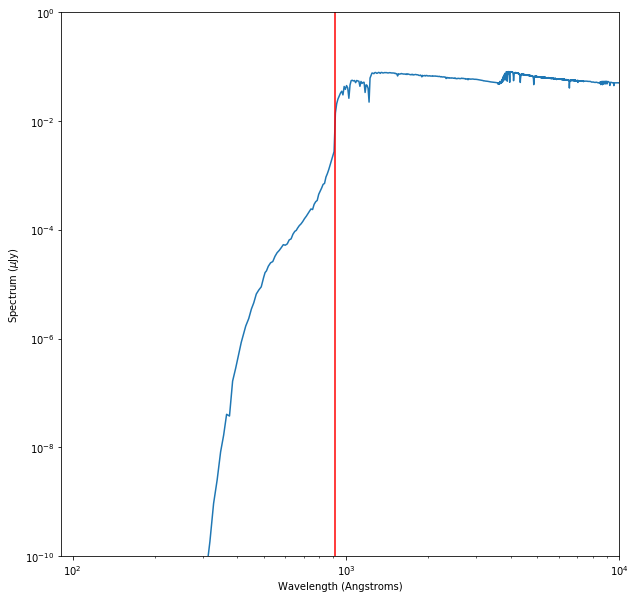

In [10]:
fig = plt.figure(figsize=[10,10])
plt.plot(wave, spec)
plt.axvline(lyman_lim, c='r')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Spectrum ($\mu$Jy)')
plt.xlim(0,1e4)
plt.ylim(1e-10,1e0)